1 VS 1


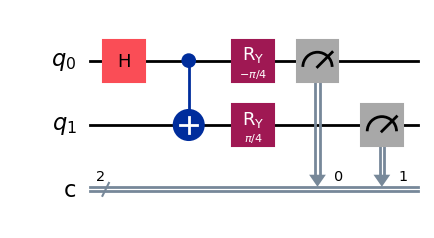

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
import random
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import io
from PIL import Image, ImageDraw, ImageFont

class QuantumRPSGame:
    def __init__(self):
        self.simulator = AerSimulator()
        self.player_wins = 0
        self.bob_wins = 0
        self.ties = 0
        self.rounds_played = 0
        self.chsh_values = []
        self.game_history = []
        self.player_choice = None
        self.output = widgets.Output()
        self.images = self.create_rps_images()
        self.setup_ui()
        
    def create_rps_images(self):
        """Create simple images for rock, paper, scissors"""
        images = {}
        size = (120, 120)
        
        # Rock image
        rock_img = Image.new('RGBA', size, (255, 255, 255, 0))
        draw = ImageDraw.Draw(rock_img)
        draw.ellipse([20, 20, 100, 100], fill=(100, 100, 100, 255), outline=(50, 50, 50, 255), width=4)
        for i in range(5):
            x, y = random.randint(30, 90), random.randint(30, 90)
            draw.ellipse([x-3, y-3, x+3, y+3], fill=(80, 80, 80, 255))
        images['Rock'] = rock_img
        
        # Scissors image
        scissors_img = Image.new('RGBA', size, (255, 255, 255, 0))
        draw = ImageDraw.Draw(scissors_img)
        draw.polygon([(30, 30), (40, 20), (50, 60), (40, 70)], fill=(180, 180, 180, 255), outline=(120, 120, 120, 255))
        draw.polygon([(70, 30), (80, 20), (90, 60), (80, 70)], fill=(180, 180, 180, 255), outline=(120, 120, 120, 255))
        draw.rectangle([45, 60, 75, 90], fill=(139, 69, 19, 255), outline=(101, 50, 14, 255), width=2)
        images['Scissors'] = scissors_img
        
        # Paper image
        paper_img = Image.new('RGBA', size, (255, 255, 255, 0))
        draw = ImageDraw.Draw(paper_img)
        draw.rectangle([25, 15, 95, 105], fill=(255, 255, 255, 255), outline=(100, 100, 100, 255), width=3)
        for i in range(25, 95, 12):
            draw.line([35, i, 85, i], fill=(200, 200, 200, 255), width=1)
        draw.polygon([(80, 15), (95, 15), (95, 30)], fill=(230, 230, 230, 255))
        images['Paper'] = paper_img
        
        return images
    
    def create_quantum_effect_image(self):
        """Create quantum effect visualization"""
        size = (200, 120)
        img = Image.new('RGBA', size, (0, 0, 0, 0))
        draw = ImageDraw.Draw(img)
        for i in range(15):
            x = random.randint(10, 190)
            y = random.randint(10, 110)
            r = random.randint(2, 8)
            colors = [(100, 200, 255), (255, 100, 200), (200, 255, 100), (255, 200, 100)]
            color = random.choice(colors)
            draw.ellipse([x-r, y-r, x+r, y+r], fill=color + (150,))
        return img
    
    def img_to_base64(self, img):
        """Convert PIL image to base64 string for HTML display"""
        buf = io.BytesIO()
        img.save(buf, format='PNG')
        buf.seek(0)
        import base64
        return base64.b64encode(buf.read()).decode()
    
    def setup_ui(self):
        """Set up user interface"""
        self.title = widgets.HTML(
            value="<h1 style='text-align: center; color: #4CAF50;'>🎮 Play Against Quantum Bob!</h1>"
        )
        
        self.rock_button = widgets.Button(
            description='🗿 Rock',
            button_style='',
            layout=widgets.Layout(width='120px', height='60px', margin='5px')
        )
        self.scissors_button = widgets.Button(
            description='✂️ Scissors',
            button_style='',
            layout=widgets.Layout(width='120px', height='60px', margin='5px')
        )
        self.paper_button = widgets.Button(
            description='📄 Paper',
            button_style='',
            layout=widgets.Layout(width='120px', height='60px', margin='5px')
        )
        
        def make_rock_choice(b):
            with self.output:
                print("Rock button pressed!")
            self.make_choice('Rock') 
        def make_scissors_choice(b):
            with self.output:
                print("Scissors button pressed!")
            self.make_choice('Scissors')
        def make_paper_choice(b):
            with self.output:
                print("Paper button pressed!")
            self.make_choice('Paper')
        
        self.rock_button.on_click(make_rock_choice)
        self.scissors_button.on_click(make_scissors_choice)
        self.paper_button.on_click(make_paper_choice)
        
        self.reset_button = widgets.Button(
            description='🔄 Reset',
            button_style='warning',
            layout=widgets.Layout(width='100px', height='40px')
        )
        self.reset_button.on_click(self.reset_game)
        
        self.score_widget = widgets.HTML(
            value=self.get_score_html()
        )
        
        self.choice_info = widgets.HTML(
            value="<div style='text-align: center; color: #666; margin: 10px;'><h3>👆 Choose your move!</h3></div>"
        )

        self.player_display = widgets.HTML(value="<div style='text-align: center;'><h3>👤 Your Move</h3><p>Waiting for selection...</p></div>")
        self.vs_widget = widgets.HTML(value="<h2 style='text-align: center; color: #FF5722;'>VS</h2>")
        self.bob_display = widgets.HTML(value="<div style='text-align: center;'><h3>🤖 Quantum Bob</h3><p>Ready...</p></div>")
        self.result_widget = widgets.HTML(value="")
        self.quantum_info = widgets.HTML(value="")

        self.game_area = widgets.VBox([
            self.title,
            self.score_widget,
            self.choice_info,
            widgets.HBox([self.rock_button, self.scissors_button, self.paper_button], 
                         layout=widgets.Layout(justify_content='center')),
            widgets.HBox([self.player_display, self.vs_widget, self.bob_display],
                         layout=widgets.Layout(justify_content='center')),
            self.result_widget,
            self.quantum_info,
            self.output
        ])
    
    def get_score_html(self):
        """Generate HTML for score display"""
        total = max(1, self.rounds_played)
        player_pct = (self.player_wins / total) * 100
        bob_pct = (self.bob_wins / total) * 100
        tie_pct = (self.ties / total) * 100
        return f"""<div style='text-align: center; margin: 20px; padding: 15px; 
                    background: linear-gradient(45deg, #e8f5e8, #f0f8ff); 
                    border-radius: 10px; border: 2px solid #4CAF50;'>
            <h3>🏆 Score after {self.rounds_played} rounds</h3>
            <p><strong>You:</strong> {self.player_wins} ({player_pct:.1f}%) | 
               <strong>Quantum Bob:</strong> {self.bob_wins} ({bob_pct:.1f}%) | 
               <strong>Ties:</strong> {self.ties} ({tie_pct:.1f}%)</p></div>"""
    
    def make_choice(self, choice):
        """Process player's choice and start the battle"""
        self.player_choice = choice
        print(f"🎯 Move selected: {choice}")
        choice_emojis = {"Rock": "🗿", "Scissors": "✂️", "Paper": "📄"}
        self.player_display.value = f"""<div style='text-align: center; background: #e3f2fd; padding: 15px; 
                    border-radius: 10px; margin: 5px; border: 2px solid #2196F3;'>
            <h3 style='color: #2196F3;'>👤 Your Move</h3>
            <div style='font-size: 48px; margin: 10px;'>{choice_emojis[choice]}</div>
            <p><strong>{choice}</strong></p></div>"""
        self.choice_info.value = "<div style='text-align: center; color: #FF5722;'><h3>⚛️ Bob is preparing his quantum move...</h3></div>"
        print("⚛️ Bob is preparing his quantum move...")
        self.show_quantum_processing()
        self.play_against_bob()
    
    def show_quantum_processing(self):
        """Show quantum state for Bob"""
        quantum_img = self.create_quantum_effect_image()
        quantum_b64 = self.img_to_base64(quantum_img)
        self.bob_display.value = f"""<div style='text-align: center; background: #fff3e0; padding: 15px; 
                    border-radius: 10px; margin: 5px; border: 2px solid #FF9800;'>
            <h3 style='color: #FF9800;'>🤖 Quantum Bob</h3>
            <img src="data:image/png;base64,{quantum_b64}" style="width: 100px; height: 60px;">
            <p>Quantum processing...</p></div>"""
    
    def create_chsh_circuit(self, alice_input, bob_input):
        """Create CHSH test circuit"""
        qr = QuantumRegister(2, 'q')
        cr = ClassicalRegister(2, 'c')
        qc = QuantumCircuit(qr, cr)

        # Create entangled Bell state
        qc.h(0)
        qc.cx(0, 1)

        # Apply rotations based on input strategies
        if alice_input == 1:
            qc.ry(-np.pi/4, 0)
        if bob_input == 1:
            qc.ry(np.pi/4, 1)
        
        # Measure both qubits
        qc.measure(0, 0)
        qc.measure(1, 1)
        return qc
    
    def play_quantum_round(self, alice_strategy, bob_strategy):
        """Run quantum circuit using AerSimulator"""
        qc = self.create_chsh_circuit(alice_strategy, bob_strategy)
        job = self.simulator.run(qc, shots=1)
        result = job.result()
        counts = result.get_counts()
        measurement = list(counts.keys())[0]
        alice_result = int(measurement[1])
        bob_result = int(measurement[0])
        return alice_result, bob_result
    
    def choice_to_strategy(self, choice):
        """Convert player choice to quantum strategy"""
        choice_map = {"Rock": 0, "Scissors": 1, "Paper": 2}
        return choice_map[choice] % 2
    
    def convert_to_rps(self, quantum_result, strategy, base_choice=None):
        """Convert quantum result to rock/paper/scissors"""
        if base_choice:
            return base_choice
        combined = (quantum_result + strategy) % 3
        moves = ['Rock', 'Scissors', 'Paper']
        return moves[combined]
    
    def determine_winner(self, player_move, bob_move):
        """Determine the winner of the round"""
        if player_move == bob_move:
            return "Tie"
        elif (player_move == "Rock" and bob_move == "Scissors") or \
             (player_move == "Scissors" and bob_move == "Paper") or \
             (player_move == "Paper" and bob_move == "Rock"):
            return "Player"
        else:
            return "Bob"
    
    def play_against_bob(self):
        """Main game logic"""
        if not self.player_choice:
            return

        # Convert choices to quantum strategies
        player_strategy = self.choice_to_strategy(self.player_choice)
        bob_strategy = random.randint(0, 1)
        
        # Play quantum round
        player_quantum, bob_quantum = self.play_quantum_round(player_strategy, bob_strategy)
        
        # Convert quantum results to RPS moves
        player_move = self.player_choice
        bob_move = self.convert_to_rps(bob_quantum, bob_strategy)
        
        # Determine winner
        winner = self.determine_winner(player_move, bob_move)
        
        # Update scores
        if winner == "Player":
            self.player_wins += 1
        elif winner == "Bob":
            self.bob_wins += 1
        else:
            self.ties += 1
        
        self.rounds_played += 1
        self.game_history.append((player_move, bob_move, winner))
        
        # Update display
        self.update_display(player_move, bob_move, winner, player_strategy, bob_strategy, 
                          player_quantum, bob_quantum)
        
        self.player_choice = None
    
    def update_display(self, player_move, bob_move, winner, player_strategy, bob_strategy,
                      player_quantum, bob_quantum):
        """Update the display with round results"""
        print(f"\n🎮 ROUND #{self.rounds_played} RESULT")
        print(f"👤 You: {player_move}")
        print(f"🤖 Bob: {bob_move}")
        
        if winner == "Player":
            print("🎉 YOU WIN!")
        elif winner == "Bob":
            print("🤖 Bob wins!")
        else:
            print("🤝 It's a tie!")
        print(f"📊 Score: You {self.player_wins} | Bob {self.bob_wins} | Ties {self.ties}")
        print(f"⚛️ Your strategy: {player_strategy}, Bob: {bob_strategy} → {bob_quantum}")
        print("-" * 50)

        # Update score display
        self.score_widget.value = self.get_score_html()
        
        # Update Bob's display with his move
        choice_emojis = {"Rock": "🗿", "Scissors": "✂️", "Paper": "📄"}
        self.bob_display.value = f"""
        <div style='text-align: center; background: #fff3e0; padding: 15px; border-radius: 10px; margin: 5px; border: 2px solid #FF9800;'>
            <h3 style='color: #FF9800;'>🤖 Quantum Bob</h3>
            <div style='font-size: 48px; margin: 10px;'>{choice_emojis[bob_move]}</div>
            <p><strong>{bob_move}</strong></p>
            <small>Strategy: {bob_strategy} | Quantum: {bob_quantum}</small></div>"""

        # Update result display
        if winner == "Player":
            winner_color = "#4CAF50"
            winner_text = "🎉 YOU WIN!"
        elif winner == "Bob":
            winner_color = "#FF5722"
            winner_text = "🤖 Bob wins!"
        else:
            winner_color = "#FF9800"
            winner_text = "🤝 It's a tie!"
        
        self.result_widget.value = f"""<div style='text-align: center; margin: 20px; padding: 15px; 
                    background: {winner_color}20; border-radius: 15px; 
                    border: 3px solid {winner_color};'>
            <h2 style='color: {winner_color};'>{winner_text}</h2>
            <p>Round #{self.rounds_played}</p></div>"""
            
        # Update quantum info display
        self.quantum_info.value = f"""<div style='text-align: center; margin: 15px; padding: 10px; 
                    background: linear-gradient(45deg, #e8f5e8, #f0f8ff); 
                    border-radius: 10px;'>
            <h4>⚛️ Quantum Details</h4>
            <p>Your move: {player_move} (strategy: {player_strategy})<br>
               Bob used quantum entanglement to generate his move<br>
               Quantum result: {bob_quantum} → {bob_move}</p></div>"""

        # Reset choice info
        self.choice_info.value = "<div style='text-align: center; color: #666; margin: 10px;'><h3>👆 Choose your next move!</h3></div>"

    def reset_game(self, button):
        """Reset the game"""
        with self.output:
            print("🔄 Resetting game...")
            
        self.player_wins = 0
        self.bob_wins = 0
        self.ties = 0
        self.rounds_played = 0
        self.game_history = []
        self.player_choice = None
        
        # Reset all displays
        self.score_widget.value = self.get_score_html()
        self.player_display.value = "<div style='text-align: center;'><h3>👤 Your Move</h3><p>Waiting for selection...</p></div>"
        self.bob_display.value = "<div style='text-align: center;'><h3>🤖 Quantum Bob</h3><p>Ready...</p></div>"
        self.result_widget.value = ""
        self.quantum_info.value = ""
        self.choice_info.value = "<div style='text-align: center; color: #666; margin: 10px;'><h3>👆 Choose your move!</h3></div>"
        
        with self.output:
            self.output.clear_output()
            print("🔄 Game reset! Ready for a new battle.")
            
    def display(self):
        """Display the game interface"""
        return self.game_area
        
    def show_stats(self):
        """Display detailed statistics"""
        if not self.game_history:
            print("No rounds played yet!")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        
        # Win distribution pie chart
        labels = ['You', 'Quantum Bob', 'Ties']
        sizes = [self.player_wins, self.bob_wins, self.ties]
        colors = ['lightgreen', 'lightcoral', 'lightgray']
        ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax1.set_title('Win Distribution')

        # Move frequency bar chart
        player_moves = [move[0] for move in self.game_history]
        bob_moves = [move[1] for move in self.game_history]
        
        move_counts_player = {move: player_moves.count(move) for move in ['Rock', 'Scissors', 'Paper']}
        move_counts_bob = {move: bob_moves.count(move) for move in ['Rock', 'Scissors', 'Paper']}
        
        x = np.arange(len(move_counts_player))
        width = 0.35
        
        ax2.bar(x - width/2, list(move_counts_player.values()), width, label='You', color='lightgreen')
        ax2.bar(x + width/2, list(move_counts_bob.values()), width, label='Quantum Bob', color='lightcoral')
        ax2.set_xlabel('Moves')
        ax2.set_ylabel('Count')
        ax2.set_title('Move Frequency')
        ax2.set_xticks(x)
        ax2.set_xticklabels(list(move_counts_player.keys()))
        ax2.legend()

        # CHSH values over time (if available)
        if self.chsh_values:
            ax3.plot(self.chsh_values, 'o-', color='purple', markersize=6)
            ax3.axhline(y=2, color='red', linestyle='--', label='Classical boundary')
            ax3.set_xlabel('Test number')
            ax3.set_ylabel('|CHSH value|')
            ax3.set_title('Quantum advantage over time')
            ax3.legend()
            ax3.grid(True, alpha=0.3)

        # Score evolution over time
        player_score_history = []
        bob_score_history = []
        player_wins_temp = 0
        bob_wins_temp = 0
        
        for _, _, winner in self.game_history:
            if winner == "Player":
                player_wins_temp += 1
            elif winner == "Bob":
                bob_wins_temp += 1
            player_score_history.append(player_wins_temp)
            bob_score_history.append(bob_wins_temp)
        
        ax4.plot(player_score_history, label='You', color='green', linewidth=2)
        ax4.plot(bob_score_history, label='Quantum Bob', color='red', linewidth=2)
        ax4.set_xlabel('Round')
        ax4.set_ylabel('Wins')
        ax4.set_title('Score Evolution')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# Example usage of the CHSH circuit
a_input = 1
b_input = 1
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(2, 'c')
qc = QuantumCircuit(qr, cr)
qc.h(0)
qc.cx(0, 1)
if a_input == 1:
    qc.ry(-np.pi/4, 0)
if b_input == 1:
    qc.ry(np.pi/4, 1)    
qc.measure(0, 0)
qc.measure(1, 1)
print(f"{a_input} VS {b_input}")
qc.draw('mpl')

In [3]:
game = QuantumRPSGame()
display(game.display())

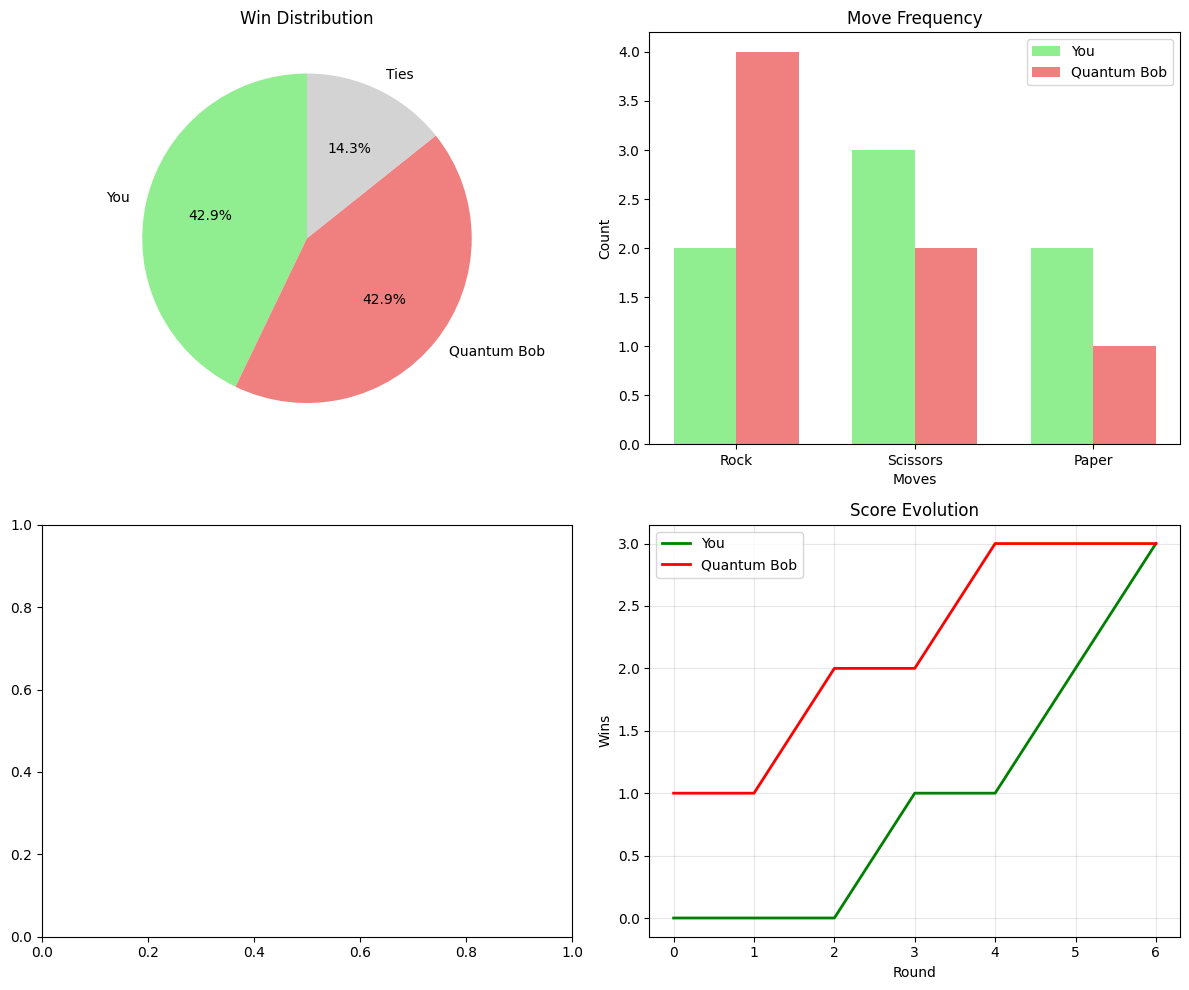

In [4]:
game.show_stats()